# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import pandas as pd
import scipy 

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from collections import Counter

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"

    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.

        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.total_loss = []

    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1./(1. + np.exp(-X.dot(weights)))

    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        loss = (np.log(1+np.exp(-np.dot(x, weights)*y))).mean() + 1/(2*self.C)*np.amin((np.linalg.norm(weights))**2)
        self.total_loss.append(loss)
        return loss

    def fit(self, X, y):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]
                          )  # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features)
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features)  # random weight initialization
        delta = 0
        for i in range(self.max_iter):
            delta = X_ext.T @ (y * (1. - 1. / (1 + np.exp(np.dot(-X_ext,
                               self.weights_) * y)))) / len(y) - (1 / self.C) * self.weights_
            self.weights_ -= self.eta * delta * (-1.)
            self.get_loss(X_ext, self.weights_, y)
            if np.linalg.norm(delta) < self.tol:
                break

    def predict_proba(self, X):
        """Predict positive class probabilities.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else:
            raise NotFittedError(
                "CustomLogisticRegression instance is not fitted yet")

    def predict(self, X):
        """Predict classes.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>

        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [5]:
from sklearn import datasets
from sklearn import metrics

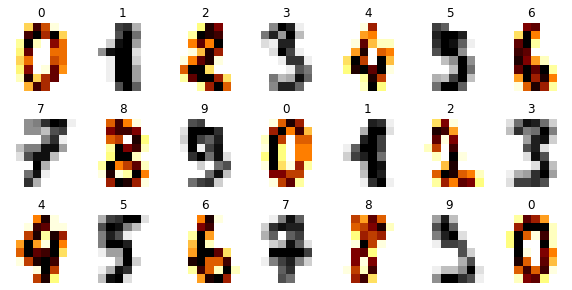

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
X_train.shape

(1437, 64)

In [13]:
len(lr_clf.weights_)

65

In [14]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [15]:
model = CustomLogisticRegression()

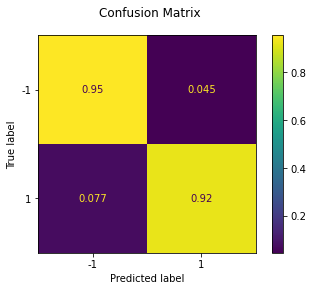

In [16]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [17]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [18]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Text(0.5, 1.0, 'Зависимость функции потерь от времени')

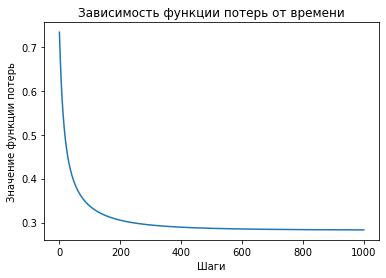

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(model.total_loss)
ax.set_xlabel('Шаги')
ax.set_ylabel('Значение функции потерь')
ax.set_title('Зависимость функции потерь от времени')

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [20]:
model_1 = CustomLogisticRegression(eta=0.005)
model_2 = CustomLogisticRegression(eta=0.01)
model_3 = CustomLogisticRegression(eta=0.015)

In [21]:
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

Text(0.5, 1.0, 'Зависимость функции потерь от времени')

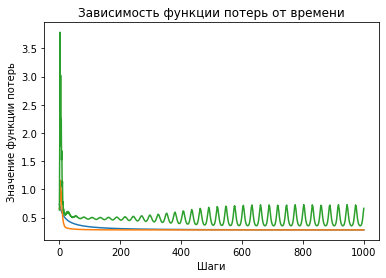

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(model.total_loss)
ax.plot(model_1.total_loss)
ax.plot(model_2.total_loss)
ax.set_xlabel('Шаги')
ax.set_ylabel('Значение функции потерь')
ax.set_title('Зависимость функции потерь от времени')

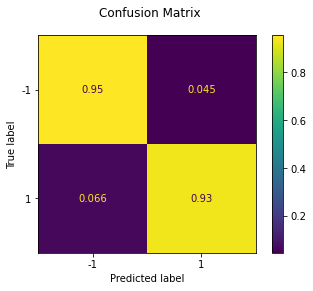

In [23]:
train_acc, test_acc = fit_evaluate(model_1, X_train, y_train, X_test, y_test)

Text(0.5, 1.0, 'Зависимость функции потерь от времени')

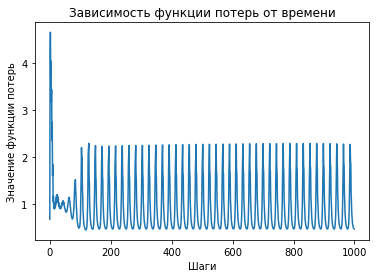

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(model_3.total_loss)
ax.set_xlabel('Шаги')
ax.set_ylabel('Значение функции потерь')
ax.set_title('Зависимость функции потерь от времени')

Как видно на графиках, при изменении teta на 0,1 наша модель улучшается. Однако дальнейшее увеличение приводит к тому, что наша модель не может найти оптимальную функцию потерь и подбирает значения около идеального состояния.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [25]:
model_4 = CustomLogisticRegression(C=0.5)
model_5 = CustomLogisticRegression(C=1.5)
model_6 = CustomLogisticRegression(C=2.0)

In [26]:
model_4.fit(X_train, y_train)
model_5.fit(X_train, y_train)
model_6.fit(X_train, y_train)

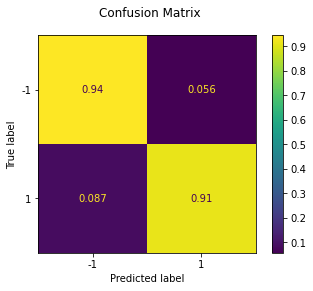

Качество модели при C=0.5


In [27]:
train_acc, test_acc = fit_evaluate(model_4, X_train, y_train, X_test, y_test)
print('Качество модели при C=0.5')

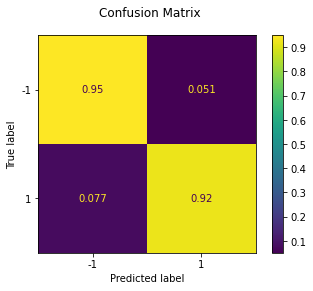

Качество модели при C=1


In [28]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Качество модели при C=1')

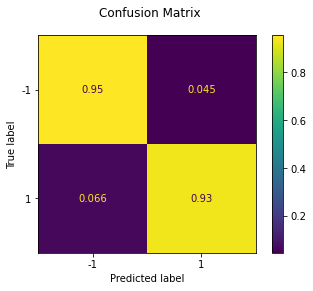

Качество модели при C=1.5


In [29]:
train_acc, test_acc = fit_evaluate(model_5, X_train, y_train, X_test, y_test)
print('Качество модели при C=1.5')

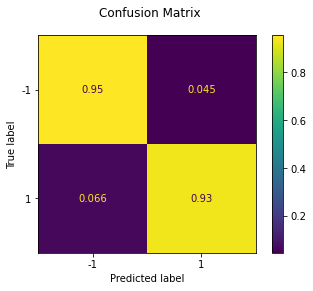

Качество модели при C=2.0


In [30]:
train_acc, test_acc = fit_evaluate(model_6, X_train, y_train, X_test, y_test)
print('Качество модели при C=2.0')

Ошибка при уменьшении C увеличивается. А при увеличении С изменяться только результаты у TN и FP ответах.

**(0.5 points)** Compare zero initialization and random initialization. 

In [31]:
model_7 = CustomLogisticRegression(zero_init=True)

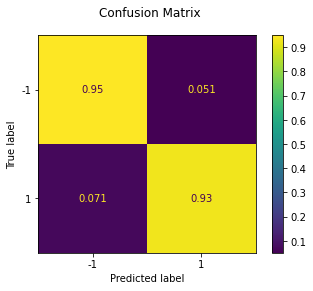

Качество модели при рандомной инициализации


In [32]:
train_acc, test_acc = fit_evaluate(model_7, X_train, y_train, X_test, y_test)
print('Качество модели при рандомной инициализации')

In [33]:
model_8 = CustomLogisticRegression(zero_init=False)

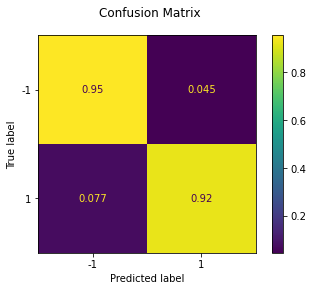

Качество модели при рандомной инициализации


In [34]:
train_acc, test_acc = fit_evaluate(model_8, X_train, y_train, X_test, y_test)
print('Качество модели при рандомной инициализации')

Как видно на графиках, модель c zero_init=False имеет чутка лучшие результаты в TN. 

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [35]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"

    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.

        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps

    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P = np.add.outer(np.sum(X**2, axis=1), np.sum(Y**2, axis=1))
        N = np.dot(X, Y.T)
        self.dist = np.sqrt(P - 2*N)
        return self.dist
        # <your code>
        # pass

    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        weights_total = []
        df_weig = pd.DataFrame(weights)
        df_weig['metrics'] = y
        #print(df_weig)
        att = df_weig.groupby('metrics').sum().to_dict()
        weights_total = []
        for i in self.classes_:
            try:
                weights_total.append(att[0][i])
            except: weights_total.append(0)
        return weights_total
        #for i in self.classes_:
        #    df_weig.groupby('metrics').sum()
        #    weight_1 = int(df_weig.loc[i].sum())
        #    weights_total.append(weight_1)
            
        #print(weights_total)
        #return weights_total
        # pass

    def fit(self, X, y):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)

    def predict_proba(self, X):
        """Predict positive class probabilities.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            p_dist_less = np.sort(P, axis=1)[:, : self.n_neighbors]
            y_dist_less = self.y[P.argsort(axis=1)[:, : self.n_neighbors]]
            #return p_dist_less, y_dist_less
            weights_of_points = np.ones(P.shape)
            weights_of_points = np.ones(p_dist_less.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(p_dist_less+self.eps)
            weights_2 = []
            #print(weights_of_points.shape)
            #print(y_dist_less.shape)
            #print(weights_of_points.shape)
            for i in range(weights_of_points.shape[0]):
                #print(i)
                weights_2.append(self.get_class_weights(y_dist_less[i], weights_of_points[i]))
            y_pobability = np.array(weights_2)/np.sum(weights_2, axis = 1)[:,None]
            return y_pobability
            # <your code>
            #pass

        else:
            raise NotFittedError(
                "CustomKNeighborsClassifier instance is not fitted yet")

    def predict(self, X):
        """Predict classes.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        predict_proba_result = self.predict_proba(X)
        atttttt = pd.DataFrame(predict_proba_result, columns = self.classes_)
        return list(atttttt.idxmax(axis=1, skipna=True))
        #final_output = []
        #for i in range(len(X)):
        #    d = []
        #    votes = []
        #    for j in range(len(X)):
        #        dist = scipy.spatial.distance.euclidean(self.points[j], X[i])
        #        d.append([dist, j])
        #    d.sort()
        #    d = d[0:self.n_neighbors]
        #    for d, j in d:
        #        votes.append(self.y[j])
        #    ans = Counter(votes).most_common(1)[0][0]
        #    final_output.append(ans)
        #return np.array(final_output)
        # <your code>
        # pass
        

In [36]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [37]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [38]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

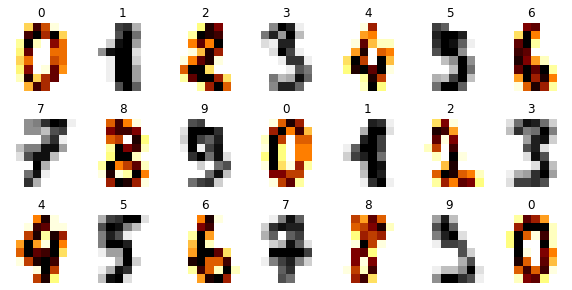

In [39]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [40]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [41]:
np.unique(list(map(int, y_train)))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

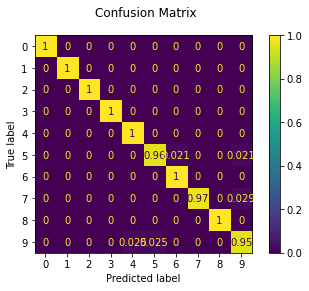

In [43]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [44]:
train_acc, test_acc

(1.0, 0.9861111111111112)

In [45]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

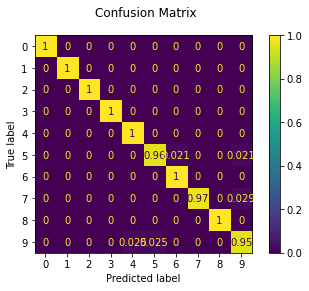

(1.0, 0.9861111111111112)

In [46]:
fit_evaluate(model, X_train, y_train, X_test, y_test)

Модель ошибается в предсказании числе 5, 7 и 9.    
5 модель путает с 6 и 9    
7 модель путает с 9    
9 модель путает с 4 и 5     


**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [47]:
model_knn_2 = CustomKNeighborsClassifier(n_neighbors=3)

Модель при n_neighbors = 3


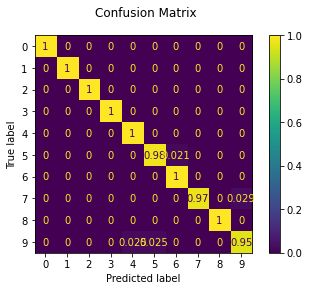

(0.9909533750869868, 0.9888888888888889)

In [52]:
print('Модель при n_neighbors = 3')
fit_evaluate(model_knn_2, X_train, y_train, X_test, y_test)

In [53]:
model_knn_3 = CustomKNeighborsClassifier(n_neighbors=7)

Модель при n_neighbors = 7


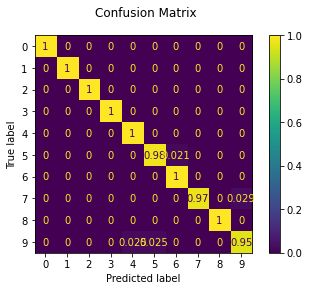

(0.9909533750869868, 0.9888888888888889)

In [54]:
print('Модель при n_neighbors = 7')
fit_evaluate(model_knn_3, X_train, y_train, X_test, y_test)

При увеличении количества ближайших соседей и уменьшении модель, судя по метрикам ухудшается.
Оптимальный параметр n_neighbors в данном случаи равен 5. 

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## задача не решена
## Прошу обратить внимание на модуль 3

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Сушествует несколько способо измерить растояние как:    
Манхэттен Метод    
Евклидонский метод    
Минковский метод    
Расстояние Махаланобиса    
Однако для данной задачи я думаю больше всего подойдет именно евклидово растояние. 

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

In [336]:
## задача не решена
## Прошу обратить внимание на модуль 3

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [337]:
#PATH = "./data/"
#data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [338]:
data = pd.read_csv('train.csv').set_index('PassengerId')

In [339]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

<AxesSubplot:xlabel='Sex', ylabel='count'>

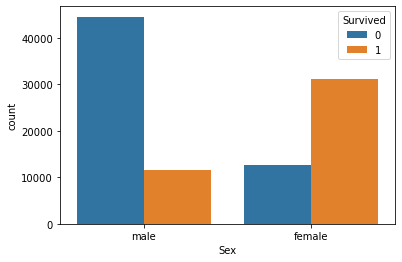

In [340]:
sns.countplot(x='Sex', hue='Survived', data = data)

In [341]:
data.groupby('Sex').size()

Sex
female    43886
male      56114
dtype: int64

Всего в дата сете представлено 43886 женщин и 56114 мужчин.     
Как видно на графике женщины выживали чаще чем мужчины.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

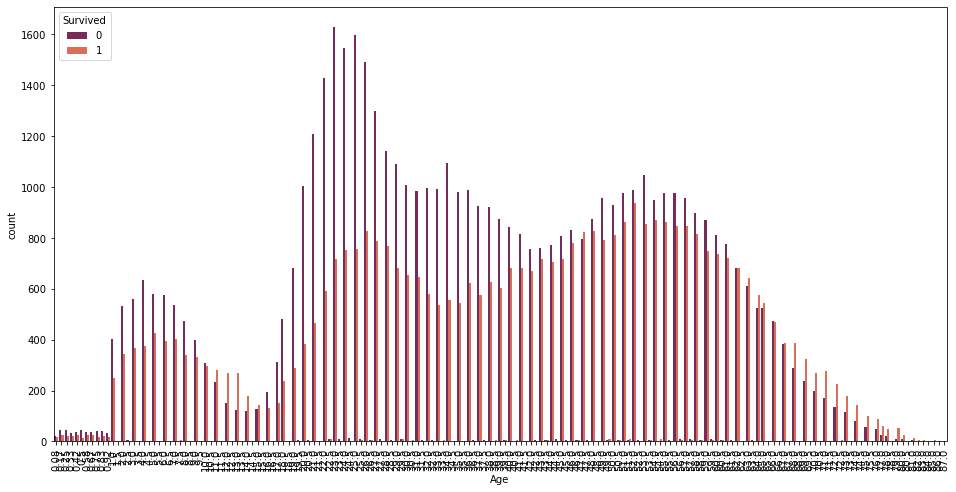

In [342]:
plt.figure(figsize=(16, 8))
ax = sns.countplot(x='Age', hue='Survived',  data=data, palette="rocket")
ax.tick_params(axis='x', labelrotation=90)

In [343]:
data.Age.describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

In [344]:
print('Медианный возраст')
data.groupby('Survived').median()['Age']

Медианный возраст


Survived
0    36.0
1    43.0
Name: Age, dtype: float64

In [345]:
print('Средний возраст')
data.groupby('Survived').mean()['Age']

Средний возраст


Survived
0    36.708695
1    40.553799
Name: Age, dtype: float64

Выборка распределена неравномерно.     
Больше всего у нас людей в возрасте от 20 до 30.     
Медиана - 39 лет.     
средний возраст 38 лет.    
а мода 25 лет.    
Наиболее ярко у нас выделены 4 группы.    
1 - дети до 10 лет.    
2 - люди в возрасте от 20 до 30.    
3 - в возрасте от 30 до 40.    
4 - в возрасте от 40 до 58.    
Медианный и средний возраст у пассажиров, которые не спаслись ниже.     

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Text(0.5, 1.0, 'Распределение embarked в разрезе выживших и не выживших пассажиров')

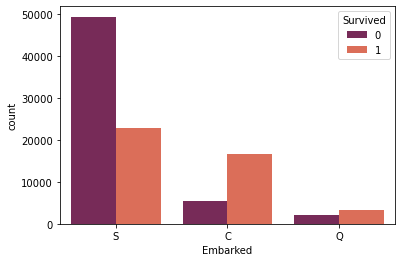

In [346]:
sns.countplot(x='Embarked', hue='Survived',  data=data, palette="rocket")
ax.set_title('Распределение embarked в разрезе выживших и не выживших пассажиров')

Text(0.5, 1.0, 'Распределение Pclass в разрезе выживших и не выживших пассажиров')

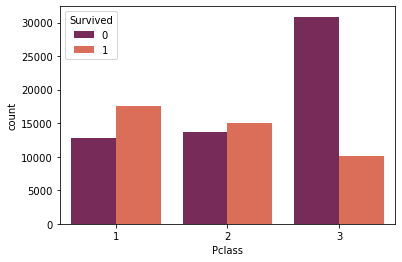

In [347]:
sns.countplot(x='Pclass', hue='Survived', data=data, palette="rocket")
ax.set_title('Распределение Pclass в разрезе выживших и не выживших пассажиров')

Пассажира третьего класса выживают чаще, так же люди сервису в порту S выживают чаще.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [348]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
## your code

Survived - 0%
Pclass - 0%
Name - 0%
Sex - 0%
Age - 3%
SibSp - 0%
Parch - 0%
Ticket - 5%
Fare - 0%
Cabin - 68%
Embarked - 0%


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

В целом у нас есть пропуски только в трех признаках. Age, Ticket , Cabin 
Колонку Cabin - я бы удалил, так как в ней 68% пропусков. Предварительно можно достать из имеющихся данных полезную информацию. Так же не имеется возможности заполнить пропуски, т.к. это не цифирная информация.
Колонку Ticket так не пре предоставляется возможности заполнить, т.к. она содержит точную уникальную информацию по номерам. Её можно использовать только для feature engineering. 
Колонку Age можно заполнить медианой или средним возрастом. Это как бы уцентрит наши данные, так же можно заполнить на основе средней информации выжил ли пассажир или нет. и внести среднею по этой группе. Это позволит лучше обучить модель, чем просто заполнить данные средними.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [349]:
data_1 = data.copy()

In [350]:
data_1.dropna(inplace = True)

In [351]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30881 entries, 8 to 99995
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  30881 non-null  int64  
 1   Pclass    30881 non-null  int64  
 2   Name      30881 non-null  object 
 3   Sex       30881 non-null  object 
 4   Age       30881 non-null  float64
 5   SibSp     30881 non-null  int64  
 6   Parch     30881 non-null  int64  
 7   Ticket    30881 non-null  object 
 8   Fare      30881 non-null  float64
 9   Cabin     30881 non-null  object 
 10  Embarked  30881 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 2.8+ MB


In [352]:
LE_coder = LabelEncoder()

In [353]:
data_1['Sex'] = LE_coder.fit_transform(data_1['Sex'])

In [354]:
KNN_model_1 = KNeighborsClassifier()

In [355]:
knn_model_1 = cross_validate(KNN_model_1, data_1[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']],
                             data_1['Survived'], scoring='accuracy', cv=5, return_train_score=True)

In [356]:
knn_model_1

{'fit_time': array([0.07000184, 0.05800176, 0.06100416, 0.07300615, 0.05700469]),
 'score_time': array([0.22001672, 0.2300179 , 0.22613978, 0.23606682, 0.23706675]),
 'test_score': array([0.6624575 , 0.66175518, 0.65204016, 0.65220207, 0.65495466]),
 'train_score': array([0.76607027, 0.76648452, 0.77097753, 0.76818458, 0.7670512 ])}

In [357]:
LG_model_1 = LogisticRegression(max_iter=1000,random_state=42)

In [358]:
LG_model_1 = cross_validate(LG_model_1, data_1[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']],
                             data_1['Survived'], scoring='accuracy', cv=5, return_train_score=True)

In [359]:
LG_model_1

{'fit_time': array([0.15500832, 0.1490109 , 0.12801027, 0.17301631, 0.14501095]),
 'score_time': array([0.00300074, 0.0019989 , 0.00214982, 0.00199747, 0.00300217]),
 'test_score': array([0.71005342, 0.71632124, 0.71016839, 0.70984456, 0.70854922]),
 'train_score': array([0.71158517, 0.70953248, 0.71111111, 0.71111111, 0.71175875])}

Сравним результаты

In [360]:
print('KNN модель')
print(knn_model_1['test_score'])
print('LogisticRegression')
print(LG_model_1['test_score'])

KNN модель
[0.6624575  0.66175518 0.65204016 0.65220207 0.65495466]
LogisticRegression
[0.71005342 0.71632124 0.71016839 0.70984456 0.70854922]


Если судить по метрикам test_score, то лучше всего у нас предсказывает результат логистическая регрессия. 

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

### Добавим несколько признаков.

In [361]:
data_2 = data.copy()

In [362]:
data_2['Sex'] = LE_coder.fit_transform(data_2['Sex'])
data_2['Embarked'] = LE_coder.fit_transform(data_2['Embarked'])

In [363]:
# заполним пропуски медианными значениями, в зависемости выжил пасажир или нет
data_2.loc[(data_2.Age.isnull()) & (data_2.Survived == 1), ('Age')] = 43.0
data_2.loc[(data_2.Age.isnull()) & (data_2.Survived == 0), ('Age')] = 36.0

In [364]:
data_2.groupby('Pclass').mean()['Fare']

Pclass
1    92.653113
2    25.756003
3    20.618226
Name: Fare, dtype: float64

In [365]:
# заполним пропуски в Fare средними значениями, в зависемости от класса
data_2.loc[(data_2.Fare.isnull()) & (data_2.Pclass == 1), ('Fare')] = 92.653113
data_2.loc[(data_2.Fare.isnull()) & (data_2.Pclass == 2), ('Fare')] = 25.756003
data_2.loc[(data_2.Fare.isnull()) & (data_2.Pclass == 3), ('Fare')] = 20.618226

In [366]:
# Добавим признак. Есть ли в билете буквенная приставка.
data_2['ticket_tipe'] = data_2.Ticket.apply(lambda x: len(str(x).split())-1)

In [367]:
# Добавим признак. Первая буква в номере кабине. Иначе ставим 0.
data_2['letter'] = data_2['Cabin'].apply(lambda x: '0' if x is np.nan else str(x)[:1])

In [368]:
data_2['first_name'] = data_2['Name'].apply(lambda x: x.split(',')[0])
data_2['second_name'] = data_2['Name'].apply(lambda x: x.split(',')[1])

In [369]:
data_2['age_mod_0'] = 36.0
data_2['age_mod_1'] = 43.0

In [370]:
data_2['age_mod_0_deviation'] = data_2.apply(lambda x: x['Age'] - x['age_mod_0'], axis = 1)
data_2['age_mod_1_deviation'] = data_2.apply(lambda x: x['Age'] - x['age_mod_1'], axis = 1)


In [371]:
data_2['first_name'] = LE_coder.fit_transform(data_2['first_name'])
data_2['second_name'] = LE_coder.fit_transform(data_2['second_name'])
data_2['letter'] = LE_coder.fit_transform(data_2['letter'])

In [372]:
data_2.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
data_2.drop(['age_mod_1_deviation', 'age_mod_0_deviation'],
            axis=1, inplace=True)

In [373]:
scaler_L1 = StandardScaler()
data_3 = scaler_L1.fit_transform(data_2.iloc[:,1:])

In [375]:
LG_model_2 = LogisticRegression(max_iter=1000,random_state=42)

In [376]:
LG_model_2_2 = cross_validate(
    LG_model_2, data_3, data_2['Survived'], scoring='accuracy', cv=5, return_train_score=True)

In [377]:
LG_model_2_2 = LogisticRegression(max_iter=1000,random_state=42)

In [378]:
LG_model_2_2.fit(data_3, data_2['Survived'])

LogisticRegression(max_iter=1000, random_state=42)

In [379]:
answer = LG_model_2_2.predict(data_3)

In [380]:
metrics.accuracy_score(y_pred=answer, y_true=data_2['Survived'])

0.76864

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [381]:
# т.к. не была достигнута минимальный порог для получения дополнительного балла, задачу на kaggle не сабмитил.